# Prophet training
This is an auto-generated notebook. To reproduce these results, attach this notebook to the **Analytics Cluster** cluster and rerun it.
- Compare trials in the [MLflow experiment](#mlflow/experiments/2603886959903966/s?orderByKey=metrics.%60val_smape%60&orderByAsc=true)
- Navigate to the parent notebook [here](#notebook/2603886959903967) (If you launched the AutoML experiment using the Experiments UI, this link isn't very useful.)
- Clone this notebook into your project folder by selecting **File > Clone** in the notebook toolbar.

Runtime Version: _10.4.x-cpu-ml-scala2.12_

In [0]:
import mlflow
import databricks.automl_runtime

target_col = "MeanSeaTemperature"
time_col = "time"
unit = "W"

horizon = 10

## Load Data

In [0]:
from mlflow.tracking import MlflowClient
import os
import uuid
import shutil
import pandas as pd
import pyspark.pandas as ps

# Create temp directory to download input data from MLflow
input_temp_dir = os.path.join("/dbfs/tmp/", str(uuid.uuid4())[:8])
os.makedirs(input_temp_dir)

# Download the artifact and read it into a pandas DataFrame
input_client = MlflowClient()
input_data_path = input_client.download_artifacts("7094a768d8ad4aeb97a849f959f411aa", "data", input_temp_dir)

input_file_path = os.path.join(input_data_path, "training_data")
input_file_path = "file://" + input_file_path
df_loaded = ps.from_pandas(pd.read_parquet(input_file_path))

# Preview data
df_loaded.head(5)

Out[2]:

,time,MeanSeaTemperature
0,2021-09-20,15.800000
1,2021-09-21,16.284900
2,2021-09-22,16.405469
3,2021-09-23,16.551729
4,2021-09-24,16.638687


## Train Prophet model
- Log relevant metrics to MLflow to track runs
- All the runs are logged under [this MLflow experiment](#mlflow/experiments/2603886959903966/s?orderByKey=metrics.%60val_smape%60&orderByAsc=true)
- Change the model parameters and re-run the training cell to log a different trial to the MLflow experiment

### Aggregate data by `time_col`
Group the data by `time_col`, and take avearge if there are multiple `target_col` values in the same group.

In [0]:
group_cols = [time_col]
df_aggregation = df_loaded \
  .groupby(group_cols) \
  .agg(y=(target_col, "avg")) \
  .reset_index() \
  .rename(columns={ time_col : "ds" })

df_aggregation.head()

Out[3]:

,ds,y
0,2021-12-13,9.226489
1,2021-11-16,12.332216
2,2021-12-15,9.800593
3,2021-09-23,16.551729
4,2021-09-30,15.573646


In [0]:
import logging

# disable informational messages from prophet
logging.getLogger("py4j").setLevel(logging.WARNING)

In [0]:
result_columns = ["model_json", "mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

def prophet_training(history_pd):
  from hyperopt import hp
  from databricks.automl_runtime.forecast.prophet.forecast import ProphetHyperoptEstimator

  seasonality_mode = ["additive", "multiplicative"]
  search_space =  {
    "changepoint_prior_scale": hp.loguniform("changepoint_prior_scale", -6.9, -0.69),
    "seasonality_prior_scale": hp.loguniform("seasonality_prior_scale", -6.9, 2.3),
    "holidays_prior_scale": hp.loguniform("holidays_prior_scale", -6.9, 2.3),
    "seasonality_mode": hp.choice("seasonality_mode", seasonality_mode)
  }
  country_holidays = None
  run_parallel = True
 
  hyperopt_estim = ProphetHyperoptEstimator(horizon=horizon, frequency_unit=unit, metric="smape",interval_width=0.8,
                   country_holidays=country_holidays, search_space=search_space, num_folds=20, max_eval=10, trial_timeout=7173,
                   random_state=444367593, is_parallel=run_parallel)

  spark.conf.set("spark.databricks.mlflow.trackHyperopt.enabled", "false")

  results_pd = hyperopt_estim.fit(history_pd)

  spark.conf.set("spark.databricks.mlflow.trackHyperopt.enabled", "true")
 
  return results_pd[result_columns]

In [0]:
import mlflow
from databricks.automl_runtime.forecast.prophet.model import mlflow_prophet_log_model, ProphetModel

with mlflow.start_run(experiment_id="2603886959903966", run_name="PROPHET") as mlflow_run:
  mlflow.set_tag("estimator_name", "Prophet")
  mlflow.log_param("interval_width", 0.8)

  forecast_results = prophet_training(df_aggregation.to_pandas())
    
  # Log the metrics to mlflow
  avg_metrics = forecast_results[["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]].mean().to_frame(name="mean_metrics").reset_index()
  avg_metrics["index"] = "val_" + avg_metrics["index"].astype(str)
  avg_metrics.set_index("index", inplace=True)
  mlflow.log_metrics(avg_metrics.to_dict()["mean_metrics"])

  # Create mlflow prophet model
  model_json = forecast_results["model_json"].to_list()[0]
  prophet_model = ProphetModel(model_json, horizon, unit, time_col)
  mlflow_prophet_log_model(prophet_model)

WARNING:hyperopt-spark:Because the requested parallelism was None or a non-positive value, parallelism will be set to (4), which is Spark's default parallelism (4), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.
WARNING:hyperopt-spark:Hyperopt + MLflow integration is feature-flagged off. To enable automatic tracking in MLflow, set via: `spark.conf.set('spark.databricks.mlflow.trackHyperopt.enabled', 'true')` where `spark` is your SparkSession.
INFO:hyperopt-spark:To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
 0%| | 0/10 [00:00<?, ?trial/s, best loss=?]INFO:hyperopt.tpe:build_posterior_wrapper took 0.002762 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:hyperopt.tpe:build_posterior_wrapper took 0.002064 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss inf
 /databricks/spark/python/pyspark/rdd.py:980: FutureWarning: Deprecated in 3.1, Use pyspark.InheritableThread with the pinned thread mode enabled.
 warnings.warn(

 0%| | 0/10 [00:01<?, ?trial/s, best loss=?]INFO:hyperopt.tpe:build_posterior_wrapper took 0.017280 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss inf
INFO:hyperopt.tpe:build_posterior_wrapper took 0.014553 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss inf
INFO:hyperopt.tpe:build_posterior_wrapper took 0.021196 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss inf
 10%|█ | 1/10 [00:11<01:39, 11.07s/trial, best loss: 0.07402795827650835]INFO:hyperopt.tpe:build_posterior_wrapper took 0.004121 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 0.074028
 20%|██ | 2/10 [00:19<01:14, 9.27s/trial, best loss: 0.07402795827650835]INFO:hyperopt.tpe:build_posterior_wrapper took 0.003653 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 0.074028
 30%|███ | 3/10 [00:24<00:51, 7.33s/trial, best loss: 0.07402795827650835]INFO:hyperopt.tpe:build_posterior_wrapper took 0.003358 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 0.074028
 40%|████ | 4/10 [00:25<00:28, 4.83s/trial, best loss: 0.07402795827650835]INFO:hyperopt.tpe:build_posterior_wrapper took 0.003067 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 0.074028
 50%|█████ | 5/10 [00:29<00:22, 4.53s/trial, best loss: 0.07402795827650835]INFO:hyperopt.tpe:build_posterior_wrapper took 0.004061 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 0.074028
 60%|██████ | 6/10 [00:33<00:17, 4.36s/trial, best loss: 0.07402795827650835] 70%|███████ | 7/10 [00:36<00:11, 3.91s/trial, best loss: 0.07402795827650835] 80%|████████ | 8/10 [00:39<00:07, 3.62s/trial, best loss: 0.07345665636348668] 90%|█████████ | 9/10 [00:40<00:02, 2.80s/trial, best loss: 0.07235356951392122]100%|██████████| 10/10 [00:43<00:00, 2.87s/trial, best loss: 0.07235356951392122]100%|██████████| 10/10 [00:43<00:00, 4.31s/trial, best loss: 0.07235356951392122]
INFO:hyperopt.fmin:Queue empty, exiting run.
INFO:hyperopt-spark:Total Trials: 10: 10 succeeded, 0 failed, 0 cancelled.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

In [0]:
forecast_results.head(5)

Out[7]:

,model_json,mse,rmse,mae,mape,mdape,smape,coverage
0,"{""growth"": ""linear"", ""n_changepoints"": 25, ""sp...",2.458269,1.460237,1.200545,0.075014,0.062261,0.072354,0.404762


## Analyze the predicted results

In [0]:
# Load the model
run_id = mlflow_run.info.run_id
loaded_model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

2022/09/24 02:15:10 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - prophet (current: 1.0.1, required: prophet==1.0)

In [0]:
# Predict future with the default horizon
forecast_pd = loaded_model._model_impl.python_model.predict_timeseries()

In [0]:
# Plotly plots is turned off by default because it takes up a lot of storage.
# Set this flag to True and re-run the notebook to see the interactive plots with plotly
use_plotly = False

In [0]:
# Get prophet model
model = loaded_model._model_impl.python_model.model()
predict_pd = forecast_pd

### Plot the forecast with change points and trend

Out[12]:

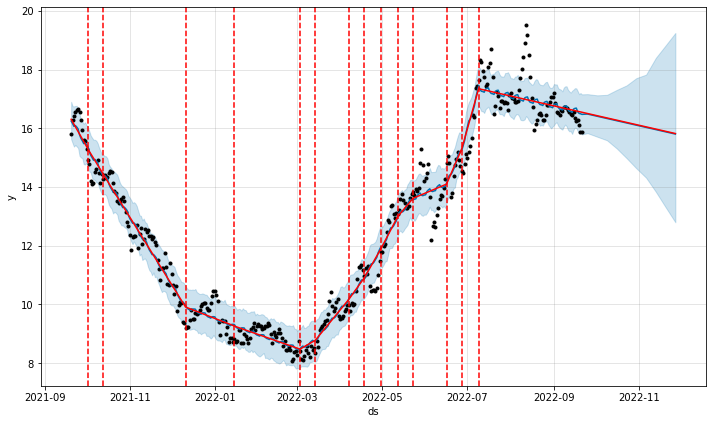

<Figure size 720x432 with 1 Axes>

In [0]:
from prophet.plot import add_changepoints_to_plot, plot_plotly

if use_plotly:
    fig = plot_plotly(model, predict_pd, changepoints=True, trend=True, figsize=(1200, 600))
else:
    fig = model.plot(predict_pd)
    a = add_changepoints_to_plot(fig.gca(), model, predict_pd)
fig

### Plot the forecast components

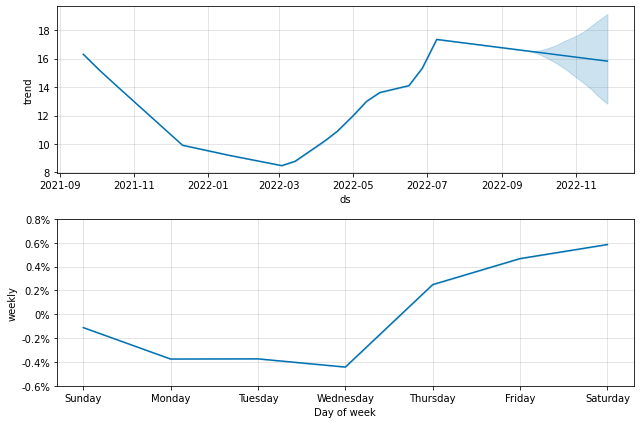

In [0]:
from prophet.plot import plot_components_plotly
if use_plotly:
    fig = plot_components_plotly(model, predict_pd, figsize=(900, 400))
    fig.show()
else:
    fig = model.plot_components(predict_pd)

## Show the predicted results

In [0]:
predict_cols = ["ds", "yhat"]
forecast_pd = forecast_pd.reset_index()
display(forecast_pd[predict_cols].tail(horizon))

ds,yhat
2022-09-25T00:00:00.000+0000,16.486070742187763
2022-10-02T00:00:00.000+0000,16.410345885767594
2022-10-09T00:00:00.000+0000,16.334621029347122
2022-10-16T00:00:00.000+0000,16.258896172927134
2022-10-23T00:00:00.000+0000,16.183171316506666
2022-10-30T00:00:00.000+0000,16.107446460086493
2022-11-06T00:00:00.000+0000,16.031721603666032
2022-11-13T00:00:00.000+0000,15.955996747245567
2022-11-20T00:00:00.000+0000,15.880271890825394
2022-11-27T00:00:00.000+0000,15.804547034404932
